# "Standard Candle" 11: Start Getting Real

Combine the work in experiment 10 with the older work in experiment 6 to have a single solid start, then bring in the basic dataloader to start getting real SDO images.

Note that this notebook should be run from the `notebooks/` subdirectory.

In [1]:
# NOTE: Change this to what the notebook name is for each experiment to ensure
# training results are saved into the right sub-directory.
notebook_name = '11_getting_real'

from collections import namedtuple, defaultdict
import math
import random
import os
import shutil
import pdb
from functools import reduce
import operator

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim

import pandas

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image

In [2]:
# Path to data and training results.
root_path = '../..' # Relative to: notebooks/01b_simple_toy
results_path = os.path.join(root_path, 'training_results', notebook_name)
model_path = os.path.join(results_path, 'model.pth')
optimizer_path = os.path.join(results_path, 'optimizer.pth')

for path in [results_path]:
  if not os.path.exists(path):
    print('{} does not exist; creating directory...'.format(os.path.abspath(path)))
    os.makedirs(path)

num_epochs = 5
batch_size_train = 64
batch_size_test = 1000
log_interval = 10
height = 28
width = 28
num_channels = 7

In [3]:
def init_gpu(cuda_device=0):
  """ Use the GPU. """
  torch.backends.cudnn.enabled = True
  if not torch.cuda.is_available():
    raise RuntimeError("CUDA not available! Unable to continue")
  # Force ourselves to use only one GPU.
  device = torch.device("cuda:{}".format(cuda_device))
  print("Using device {} for training, current device: {}, total devices: {}".format(
    device, torch.cuda.current_device(), torch.cuda.device_count()))
  return device

def set_seed(random_seed=1, deterministic_cuda=True):
  """ Force runs to be deterministic and reproducible. """
  np.random.seed(random_seed)
  random.seed(random_seed)
  torch.manual_seed(random_seed)
  torch.cuda.manual_seed(random_seed)
  os.environ['PYTHONHASHSEED'] = str(random_seed)

  # Note: this can have a performance hit.
  if deterministic_cuda:
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [4]:
device = init_gpu(cuda_device=1)
set_seed()

Using device cuda:1 for training, current device: 0, total devices: 6


In [5]:
class Net(nn.Module):
    def __init__(self, input_shape, output_dim):
        super().__init__()
        if (len(input_shape) != 3):
            raise ValueError('Expecting an input_shape representing dimensions CxHxW')
        self._input_channels = input_shape[0]
        print('input_channels: {}'.format(self._input_channels))
        self._conv2d1 = nn.Conv2d(in_channels=self._input_channels, out_channels=64, kernel_size=3)
        self._conv2d2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self._cnn_output_dim = self._cnn(torch.zeros(input_shape).unsqueeze(0)).nelement()
        print('cnn_output_dim: {}'.format(self._cnn_output_dim))
        self._fc1 = nn.Linear(self._cnn_output_dim, 256)
        self._fc2 = nn.Linear(256, output_dim)
        
    def _cnn(self, x):
        x = self._conv2d1(x)
        x = torch.relu(x)
        x = nn.MaxPool2d(kernel_size=3)(x)
        x = self._conv2d2(x)
        x = nn.MaxPool2d(kernel_size=3)(x)
        return x
    
    def forward(self, x):
        batch_dim = x.shape[0]
        x = self._cnn(x).view(batch_dim, -1)
        x = self._fc1(x)
        x = torch.relu(x)
        x = self._fc2(x)
        x = torch.sigmoid(x)
        return x

In [6]:
class SyntheticSDODataset(torch.utils.data.Dataset):
  def __init__(self, num_channels, height, width, size, length):
    self._num_channels = num_channels
    self._height = height
    self._width = width
    self._size = size
    self._length = length
    
    # TODO: Compute mean and std across dataset, and normalize them.
    
  def __getitem__(self, idx):
    sun = self._draw_sun(self._num_channels, self._size, self._height, self._width)
    dimmed_sun = sun.clone().to(device)
    dim_factor = torch.rand(num_channels).to(device)    
    for c in range(num_channels):
      dimmed_sun[c] *= dim_factor[c]
      
    return dimmed_sun, dim_factor, sun
    
  def __len__(self):
    return self._length
  
  def _draw_sun(self, num_channels, size, height, width):
    """ Draw a synthetic sun. """
    xx, yy = np.meshgrid(np.arange(size)-(size-1)/2.,
                         np.arange(size)-(size-1)/2)
    r = np.sqrt(xx*xx+yy*yy) 
    R = np.random.rand(1)*(size/3)
    channels = []
    for c in range(num_channels):
        I_c = R**(c/10.)
        channels.append(np.exp(-(r*r)/(R*R))*I_c)

    image = [torch.from_numpy(channel).float().to(device) for channel in channels]
    image = torch.cat(image).view(num_channels, height, width)

    return image

In [7]:
train_dataset = SyntheticSDODataset(num_channels, height, width, size=height, length=10000)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train,
                                           shuffle=True)

test_dataset = SyntheticSDODataset(num_channels, height, width, size=height, length=1000)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test,
                                           shuffle=True)

In [8]:
def show_sample_image(loader):
  print('\nUndimmed channels for a single original sun:\n')
  _, _, orig_sun = loader.dataset[0]
  sun_numpy = orig_sun.cpu().numpy()
  for channel in sun_numpy:
    plt.imshow(channel, norm=None, cmap='hot', vmin=sun_numpy.min(), vmax=sun_numpy.max())
    plt.show()

def print_details(orig_data, output, dimmed_data, dim_factors, train):
  print('\n\nDetails with sample from final batch:')
  data_min, data_max = torch.min(orig_data), torch.max(orig_data)
  sample = orig_data[0].cpu().numpy()
  sample_dimmed = dimmed_data[0].cpu().numpy()

  for i, (channel, channel_dimmed) in enumerate(zip(sample, sample_dimmed)):
    fig = plt.figure()
    ax1 = fig.add_subplot(1, 3, 1)
    ax1.imshow(channel, norm=None, cmap='hot', vmin=data_min, vmax=data_max)
    ax2 = fig.add_subplot(1, 3, 2)
    ax2.imshow(channel_dimmed, norm=None, cmap='hot', vmin=data_min, vmax=data_max)
    ax3 = fig.add_subplot(1, 3, 3)
    ax3.imshow(channel_dimmed / float(output[0, i]), norm=None, cmap='hot', vmin=data_min, vmax=data_max)
    print('\nChannel: {} (left: original, middle: dimmed, right: undimmed)\nDimming (true): {}, dimming (predicted): {}'.format(
      i, dim_factors[0, i], output[0, i]))
    plt.show()
  dim_factors_numpy = dim_factors[0].view(-1).cpu().numpy()
  plt.plot(dim_factors_numpy, label='Dimming factors (true)')
  output_numpy = output[0].detach().view(-1).cpu().numpy()
  plt.plot(output_numpy, label='Dimming factors (predicted)')
  title = 'training dimming factors' if train else 'testing dimming factors'
  plt.title(title)
  plt.legend()
  plt.show()

def generate_train_accuracy_stats(correct, output, targets, num_column_labels, num_subsample):
  # TODO: For efficiency reasons, convert all of this to torch rather than numpy operations
  # so that we can do all this work on the GPU.
  preds = output.detach().cpu().numpy()
  targets = targets.detach().cpu().numpy()

  # If a channel brightness prediction is within this percentage of the ground truth then we
  # consider that prediction correct.
  pct_close = 0.15

  # Means across each row that collapses each batch entries predictions,
  # the ground truth brightness, and the delta btw ground truth and prediction.
  mean_per_channel_prediction = preds.mean(axis=0)
  mean_per_channel_gt = targets.mean(axis=0)
  per_channel_diff = np.abs(targets - preds)
  mean_per_channel_diff = per_channel_diff.mean(axis=0)

  # Various stats around channel correctness.
  per_channel_correct = per_channel_diff <= np.abs(pct_close * targets)
  # TODO: We can probably get rid of both of these np.where() conversions to 1/0s and just use the boolean
  # array itself for the sum.
  percentage_channels_correct = np.sum(np.where(per_channel_correct, 1, 0), axis=1, keepdims=True,
                                       dtype=np.int)
  correct_per_channel = np.sum(np.where(per_channel_correct, 1, 0), axis=1, keepdims=True,
                               dtype=np.int)
  pct_correct_per_channel = correct_per_channel / num_channels

  # Which batch results have _all_ of their channel predictions fully correct?
  # TODO: We can probably get rid of the np.where() conversion to 1/0s and just use the boolean
  # array itself for the sum.
  num_fully_correct_all_channels = np.where(pct_correct_per_channel == 1.0, 1, 0).sum()
  pct_fully_correct_all_channels = num_fully_correct_all_channels / batch_size_test
  correct += num_fully_correct_all_channels
  
  pretty_results = np.zeros((min(batch_size_test, len(preds)), num_column_labels), dtype=np.float32)

  # The mean channel prediction across each row of the batch results.
  pretty_results[:, 0] = np.round(preds.mean(axis=1), decimals=2)

  # The mean channel ground truth across each row of the batch results.
  pretty_results[:, 1] = np.round(targets.mean(axis=1), decimals=2)

  # The mean difference btw prediction and grouth truth across each row of the batch results.
  pretty_results[:, 2] = np.round(np.abs(targets - preds).mean(axis=1), decimals=2)

  # Percentage correct across all the channels for a given batch row?
  pretty_results[:, 3] = np.round(pct_correct_per_channel * 100.0, decimals=0)[:, 0].astype(np.int)
  
  # Randomly sub-sample some of the results since 100s or 1000s are too much to display.
  lookup_idxs = np.random.choice(len(pretty_results), size=(num_subsample,))
  pretty_results = pretty_results[lookup_idxs]

  return correct, pretty_results


Undimmed channels for a single original sun:



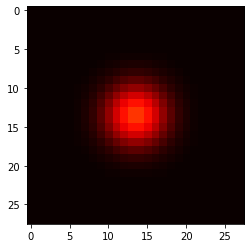

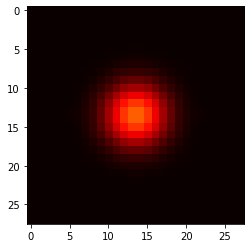

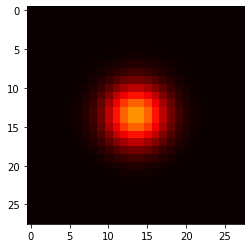

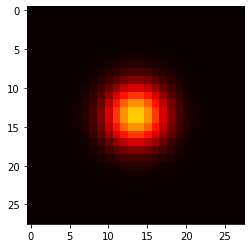

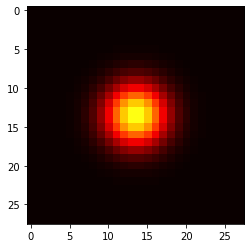

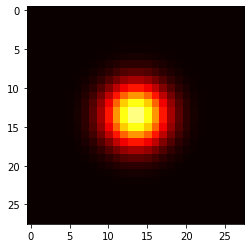

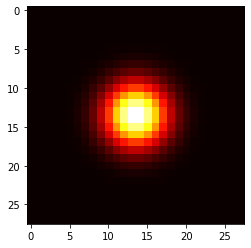

input_channels: 7
cnn_output_dim: 512


In [9]:
show_sample_image(train_loader)

model = Net(input_shape=[num_channels, height, width], output_dim=num_channels)
model.cuda(device)
optimizer = torch.optim.Adam(model.parameters())
  
def train(epoch):
  print("\n\n===================================\n\n")
  print("\n\nTraining epoch {}\n".format(epoch))
  model.train()
  losses = []
  for batch_idx, (dimmed_data, dim_factors, orig_data) in enumerate(train_loader):
    optimizer.zero_grad()
    output = model(dimmed_data)
    loss = nn.MSELoss()(output, dim_factors)
    loss.backward()
    optimizer.step()
    losses.append(float(loss))

    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(orig_data), len(train_loader.dataset),
        100.0 * (batch_idx / len(train_loader)), float(loss)))
      # TODO: Save the model.
      # torch.save(model.state_dict(), model_path)
      # torch.save(optimizer.state_dict(), optimizer_path)

  # Print extra debug output on the final batch.
  print_details(orig_data, output, dimmed_data, dim_factors, train=True)

  plt.plot(losses, label='training loss')
  plt.title('training loss')
  plt.show()
  
  print('\nAt end of train epoch {}, loss min: {}, max: {}, mean: {}'.format(epoch,
    min(losses), max(losses), np.mean(losses)))
  
  return np.mean(losses)

def test(epoch):
  print("\n\nTesting epoch {}".format(epoch))
  with torch.no_grad():
    model.eval()
    losses = []
    correct = 0
    current_batch = 0
    num_subsample = 3 # Per batch, how many results to subsample to print out for debugging.
    column_labels = ['Pred', 'GT', 'Delta', 'Pct Correct']
    pretty_results = np.zeros((int(math.ceil(len(test_loader.dataset) / batch_size_test) * num_subsample),
                               len(column_labels)), dtype=np.float32)
    for batch_idx, (dimmed_data, dim_factors, orig_data) in enumerate(test_loader):
      current_batch += 1
      dimmed_data = dimmed_data.to(device)
      dim_factors = dim_factors.to(device)
      output = model(dimmed_data)
      output = output.to(device)
      loss = nn.MSELoss()(output, dim_factors)
      losses.append(float(loss))

      correct, pretty_print_subset = generate_train_accuracy_stats(
        correct, output, dim_factors, len(column_labels), num_subsample)
      current_batch_idx = current_batch - 1
      pretty_results[current_batch_idx*num_subsample:current_batch_idx*num_subsample+num_subsample] = pretty_print_subset

    # Print extra debug output on the final batch.
    print_details(orig_data, output, dimmed_data, dim_factors, train=False)
    
    print("\n\nRandom sample of mean predictions across channels for test set, "
          "where each row is a test sample in the training batch:\n")
    df = pandas.DataFrame(pretty_results, columns=column_labels)
    print(df.to_string(index=False))
    
    print('\n\nEpoch {}, test set: avg. loss: {:.8f}, Accuracy all channels correct: {}/{} ({:.0f}%)'.format(
          epoch, np.mean(losses), correct, len(test_loader.dataset),
          100.0 * (correct / len(test_loader.dataset))))

    return np.mean(losses)







Training epoch 1

Train Epoch: 1 [0/10000 (0%)]	Loss: 0.080943
Train Epoch: 1 [640/10000 (6%)]	Loss: 0.057896
Train Epoch: 1 [1280/10000 (13%)]	Loss: 0.032224
Train Epoch: 1 [1920/10000 (19%)]	Loss: 0.030263
Train Epoch: 1 [2560/10000 (25%)]	Loss: 0.028731
Train Epoch: 1 [3200/10000 (32%)]	Loss: 0.017553
Train Epoch: 1 [3840/10000 (38%)]	Loss: 0.015109
Train Epoch: 1 [4480/10000 (45%)]	Loss: 0.025241
Train Epoch: 1 [5120/10000 (51%)]	Loss: 0.018427
Train Epoch: 1 [5760/10000 (57%)]	Loss: 0.022662
Train Epoch: 1 [6400/10000 (64%)]	Loss: 0.016122
Train Epoch: 1 [7040/10000 (70%)]	Loss: 0.013556
Train Epoch: 1 [7680/10000 (76%)]	Loss: 0.011198
Train Epoch: 1 [8320/10000 (83%)]	Loss: 0.014645
Train Epoch: 1 [8960/10000 (89%)]	Loss: 0.010335
Train Epoch: 1 [9600/10000 (96%)]	Loss: 0.008800


Details with sample from final batch:

Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.33936983346939087, dimming (predicted): 0.3333418071269989


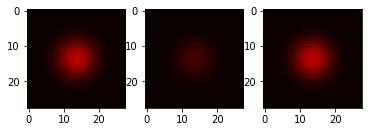


Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.39085477590560913, dimming (predicted): 0.4326504170894623


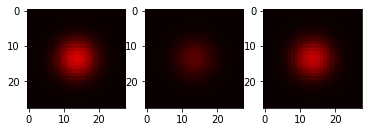


Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.14193624258041382, dimming (predicted): 0.17622904479503632


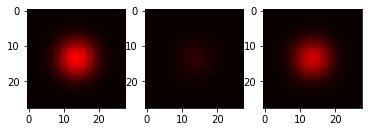


Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.1589033603668213, dimming (predicted): 0.1822584867477417


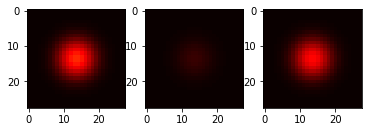


Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.1738383173942566, dimming (predicted): 0.22224745154380798


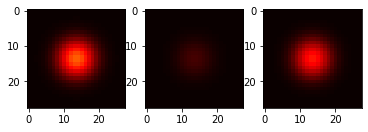


Channel: 5 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.8907366394996643, dimming (predicted): 0.9335049390792847


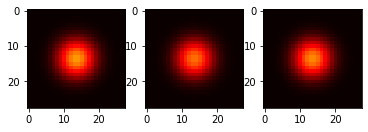


Channel: 6 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.31707602739334106, dimming (predicted): 0.357837975025177


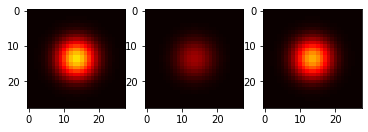

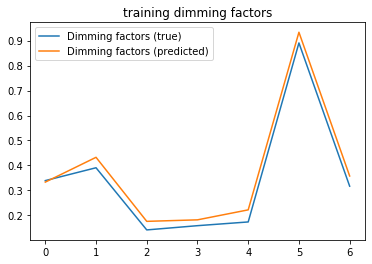

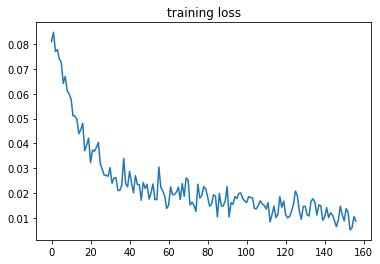


At end of train epoch 1, loss min: 0.005154712591320276, max: 0.08472461998462677, mean: 0.02341611771458748


Testing epoch 1


Details with sample from final batch:

Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.3142858147621155, dimming (predicted): 0.2562834918498993


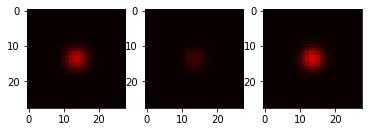


Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.31567472219467163, dimming (predicted): 0.2863079607486725


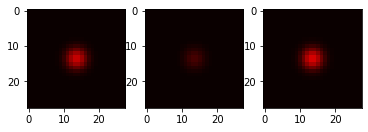


Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.24491006135940552, dimming (predicted): 0.22951160371303558


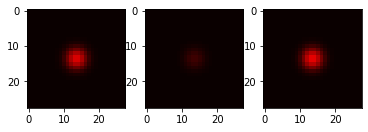


Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.6747291684150696, dimming (predicted): 0.7422330379486084


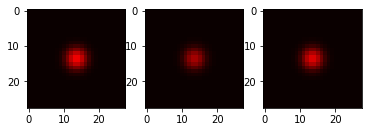


Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.5704829096794128, dimming (predicted): 0.6378729343414307


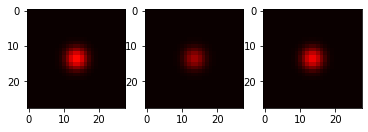


Channel: 5 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.7168473601341248, dimming (predicted): 0.8248372673988342


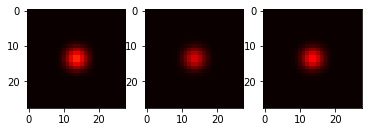


Channel: 6 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.4612531065940857, dimming (predicted): 0.526627779006958


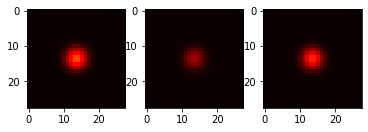

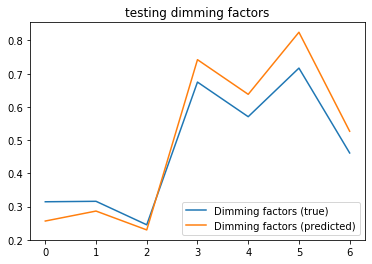



Random sample of mean predictions across channels for test set, where each row is a test sample in the training batch:

 Pred    GT  Delta  Pct Correct
 0.51  0.53   0.11         29.0
 0.69  0.78   0.09         86.0
 0.39  0.40   0.02         86.0


Epoch 1, test set: avg. loss: 0.01239238, Accuracy all channels correct: 46/1000 (5%)


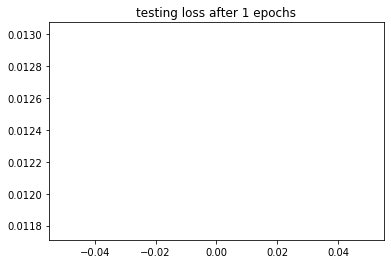







Training epoch 2

Train Epoch: 2 [0/10000 (0%)]	Loss: 0.013278
Train Epoch: 2 [640/10000 (6%)]	Loss: 0.010118
Train Epoch: 2 [1280/10000 (13%)]	Loss: 0.012131
Train Epoch: 2 [1920/10000 (19%)]	Loss: 0.015951
Train Epoch: 2 [2560/10000 (25%)]	Loss: 0.010136
Train Epoch: 2 [3200/10000 (32%)]	Loss: 0.008577
Train Epoch: 2 [3840/10000 (38%)]	Loss: 0.011530
Train Epoch: 2 [4480/10000 (45%)]	Loss: 0.007858
Train Epoch: 2 [5120/10000 (51%)]	Loss: 0.012893
Train Epoch: 2 [5760/10000 (57%)]	Loss: 0.012078
Train Epoch: 2 [6400/10000 (64%)]	Loss: 0.009399
Train Epoch: 2 [7040/10000 (70%)]	Loss: 0.009331
Train Epoch: 2 [7680/10000 (76%)]	Loss: 0.007722
Train Epoch: 2 [8320/10000 (83%)]	Loss: 0.004061
Train Epoch: 2 [8960/10000 (89%)]	Loss: 0.005092
Train Epoch: 2 [9600/10000 (96%)]	Loss: 0.011307


Details with sample from final batch:

Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.7310729622840881, dimming (predicted): 0.7799806594848633


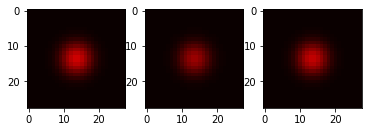


Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.07255935668945312, dimming (predicted): 0.12802481651306152


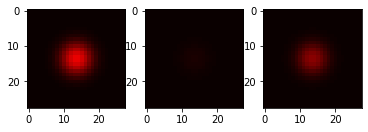


Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.3199564814567566, dimming (predicted): 0.37099310755729675


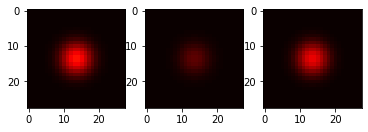


Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.7016804814338684, dimming (predicted): 0.7690322995185852


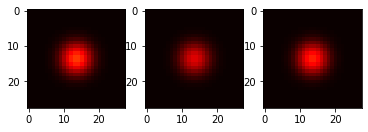


Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.10307109355926514, dimming (predicted): 0.1338353008031845


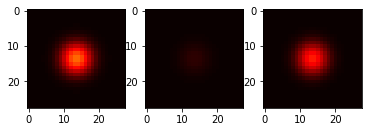


Channel: 5 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.6649295687675476, dimming (predicted): 0.6978321075439453


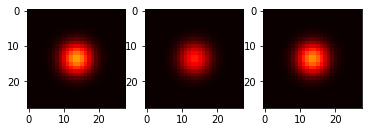


Channel: 6 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.44983822107315063, dimming (predicted): 0.4342024028301239


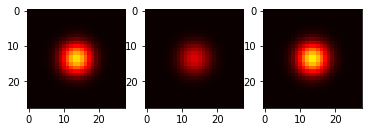

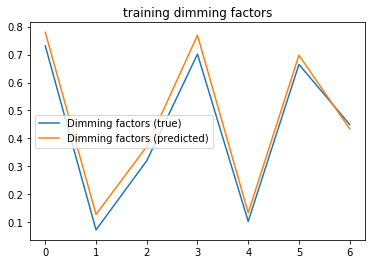

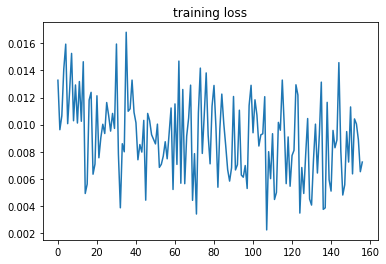


At end of train epoch 2, loss min: 0.002225837903097272, max: 0.0168217271566391, mean: 0.009105212624617822


Testing epoch 2


Details with sample from final batch:

Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.8819024562835693, dimming (predicted): 0.847529411315918


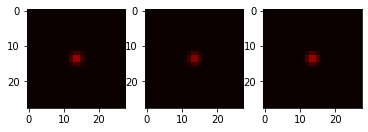


Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.183621346950531, dimming (predicted): 0.23770426213741302


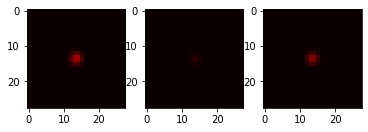


Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.627483606338501, dimming (predicted): 0.6222806572914124


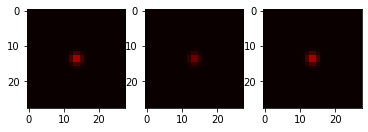


Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.08381325006484985, dimming (predicted): 0.18016251921653748


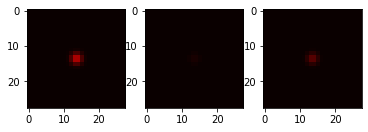


Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.028432488441467285, dimming (predicted): 0.10361213982105255


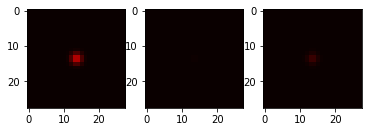


Channel: 5 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.8077515959739685, dimming (predicted): 0.8022286295890808


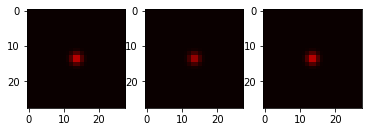


Channel: 6 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.5344738364219666, dimming (predicted): 0.597400426864624


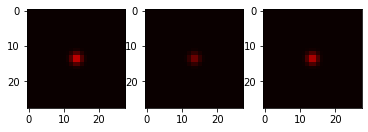

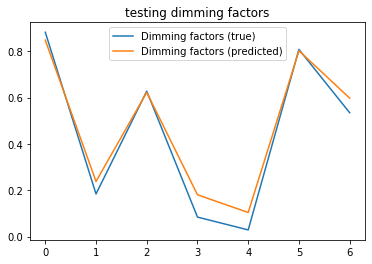



Random sample of mean predictions across channels for test set, where each row is a test sample in the training batch:

 Pred    GT  Delta  Pct Correct
 0.47  0.46   0.23         29.0
 0.51  0.51   0.03        100.0
 0.51  0.50   0.04        100.0


Epoch 2, test set: avg. loss: 0.00762953, Accuracy all channels correct: 271/1000 (27%)


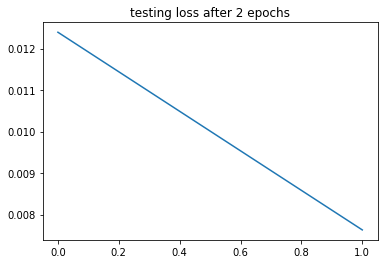







Training epoch 3

Train Epoch: 3 [0/10000 (0%)]	Loss: 0.010424
Train Epoch: 3 [640/10000 (6%)]	Loss: 0.004490
Train Epoch: 3 [1280/10000 (13%)]	Loss: 0.008764
Train Epoch: 3 [1920/10000 (19%)]	Loss: 0.006316
Train Epoch: 3 [2560/10000 (25%)]	Loss: 0.007497
Train Epoch: 3 [3200/10000 (32%)]	Loss: 0.009992
Train Epoch: 3 [3840/10000 (38%)]	Loss: 0.003178
Train Epoch: 3 [4480/10000 (45%)]	Loss: 0.010372
Train Epoch: 3 [5120/10000 (51%)]	Loss: 0.006086
Train Epoch: 3 [5760/10000 (57%)]	Loss: 0.005571
Train Epoch: 3 [6400/10000 (64%)]	Loss: 0.005675
Train Epoch: 3 [7040/10000 (70%)]	Loss: 0.012285
Train Epoch: 3 [7680/10000 (76%)]	Loss: 0.006710
Train Epoch: 3 [8320/10000 (83%)]	Loss: 0.003418
Train Epoch: 3 [8960/10000 (89%)]	Loss: 0.013336
Train Epoch: 3 [9600/10000 (96%)]	Loss: 0.005266


Details with sample from final batch:

Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.32586562633514404, dimming (predicted): 0.2841217517852783


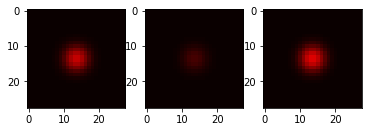


Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.8936226963996887, dimming (predicted): 0.8472051024436951


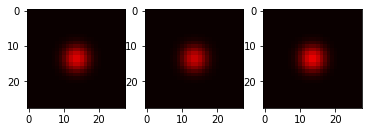


Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.07454776763916016, dimming (predicted): 0.09786570817232132


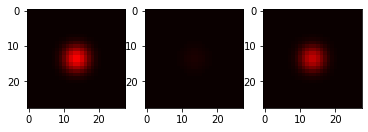


Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.8573745489120483, dimming (predicted): 0.8385704755783081


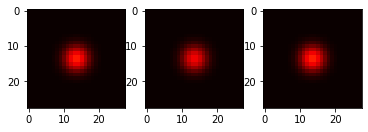


Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.18230819702148438, dimming (predicted): 0.14738024771213531


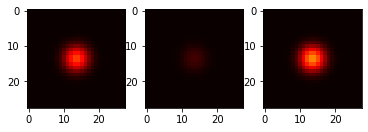


Channel: 5 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.6905968189239502, dimming (predicted): 0.6744096279144287


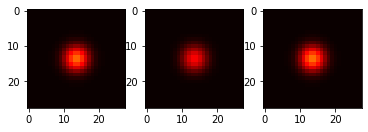


Channel: 6 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.5369908213615417, dimming (predicted): 0.5142410397529602


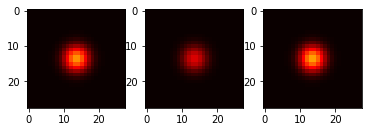

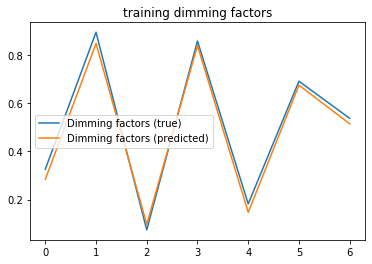

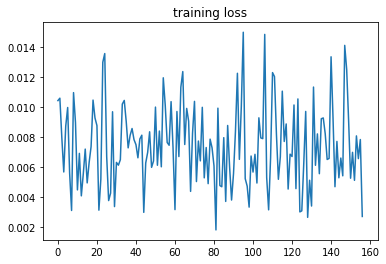


At end of train epoch 3, loss min: 0.0018303066026419401, max: 0.014966904185712337, mean: 0.0074251023444471655


Testing epoch 3


Details with sample from final batch:

Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.7482791543006897, dimming (predicted): 0.805505633354187


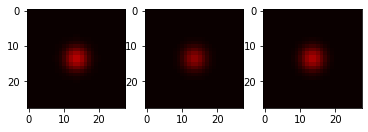


Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.08704954385757446, dimming (predicted): 0.106852687895298


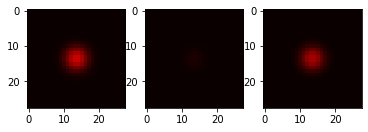


Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.9978384971618652, dimming (predicted): 0.9246231913566589


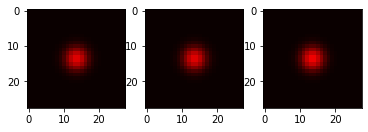


Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.8081122040748596, dimming (predicted): 0.8303181529045105


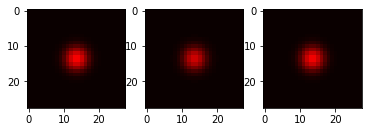


Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.0764891505241394, dimming (predicted): 0.11943209171295166


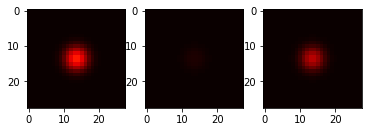


Channel: 5 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.8483579754829407, dimming (predicted): 0.8537823557853699


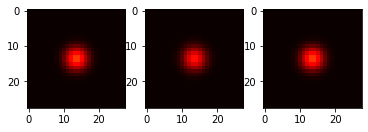


Channel: 6 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.7619020342826843, dimming (predicted): 0.7946711182594299


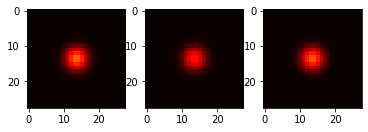

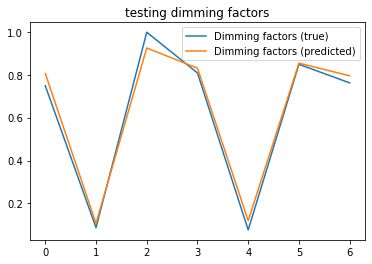



Random sample of mean predictions across channels for test set, where each row is a test sample in the training batch:

 Pred    GT  Delta  Pct Correct
 0.54  0.53   0.03        100.0
 0.53  0.52   0.02        100.0
 0.49  0.48   0.03        100.0


Epoch 3, test set: avg. loss: 0.00695588, Accuracy all channels correct: 290/1000 (29%)


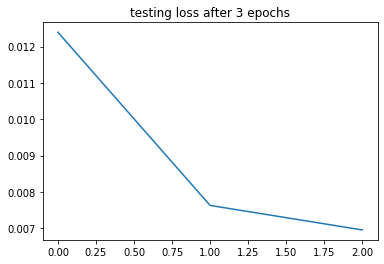







Training epoch 4

Train Epoch: 4 [0/10000 (0%)]	Loss: 0.003384
Train Epoch: 4 [640/10000 (6%)]	Loss: 0.005969
Train Epoch: 4 [1280/10000 (13%)]	Loss: 0.003023
Train Epoch: 4 [1920/10000 (19%)]	Loss: 0.005363
Train Epoch: 4 [2560/10000 (25%)]	Loss: 0.007679
Train Epoch: 4 [3200/10000 (32%)]	Loss: 0.010968
Train Epoch: 4 [3840/10000 (38%)]	Loss: 0.004073
Train Epoch: 4 [4480/10000 (45%)]	Loss: 0.007362
Train Epoch: 4 [5120/10000 (51%)]	Loss: 0.004803
Train Epoch: 4 [5760/10000 (57%)]	Loss: 0.005285
Train Epoch: 4 [6400/10000 (64%)]	Loss: 0.006351
Train Epoch: 4 [7040/10000 (70%)]	Loss: 0.010127
Train Epoch: 4 [7680/10000 (76%)]	Loss: 0.008805
Train Epoch: 4 [8320/10000 (83%)]	Loss: 0.004109
Train Epoch: 4 [8960/10000 (89%)]	Loss: 0.004346
Train Epoch: 4 [9600/10000 (96%)]	Loss: 0.009581


Details with sample from final batch:

Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.30184441804885864, dimming (predicted): 0.27285441756248474


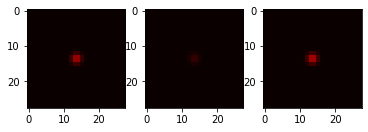


Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.9351310729980469, dimming (predicted): 0.8928304314613342


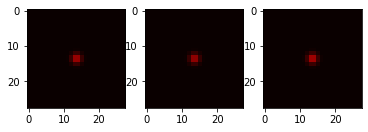


Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.6663490533828735, dimming (predicted): 0.6204980611801147


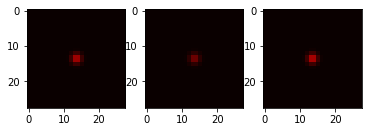


Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.36047494411468506, dimming (predicted): 0.32946088910102844


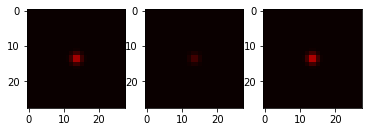


Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.872130811214447, dimming (predicted): 0.8396450281143188


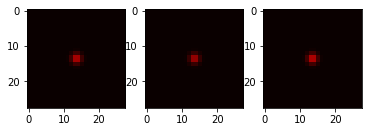


Channel: 5 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.060558021068573, dimming (predicted): 0.08162955939769745


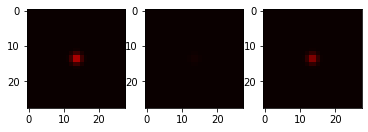


Channel: 6 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.3538684844970703, dimming (predicted): 0.357570618391037


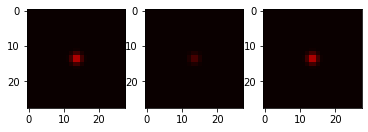

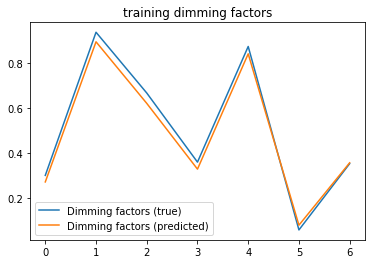

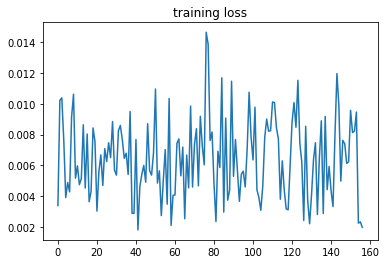


At end of train epoch 4, loss min: 0.0017973276553675532, max: 0.01466389000415802, mean: 0.0064437126905426


Testing epoch 4


Details with sample from final batch:

Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.9629555344581604, dimming (predicted): 0.9120973944664001


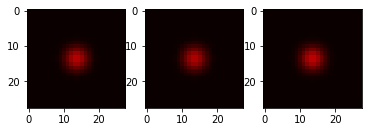


Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.42675912380218506, dimming (predicted): 0.3328591287136078


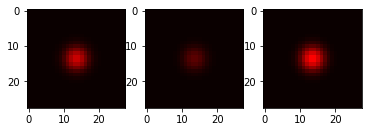


Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.8975064754486084, dimming (predicted): 0.8439961671829224


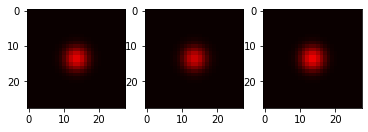


Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.1685062050819397, dimming (predicted): 0.15618905425071716


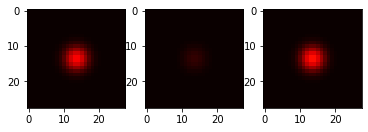


Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.03125941753387451, dimming (predicted): 0.0649704560637474


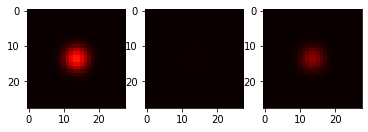


Channel: 5 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.4110509753227234, dimming (predicted): 0.3838142156600952


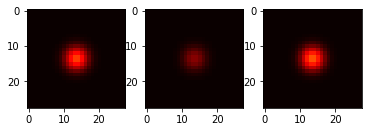


Channel: 6 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.04192072153091431, dimming (predicted): 0.06067666411399841


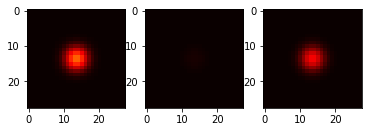

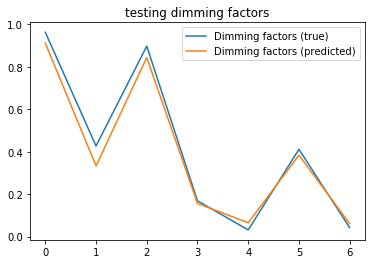



Random sample of mean predictions across channels for test set, where each row is a test sample in the training batch:

 Pred    GT  Delta  Pct Correct
 0.53  0.54   0.04         86.0
 0.52  0.52   0.03         86.0
 0.52  0.51   0.04         71.0


Epoch 4, test set: avg. loss: 0.00702733, Accuracy all channels correct: 189/1000 (19%)


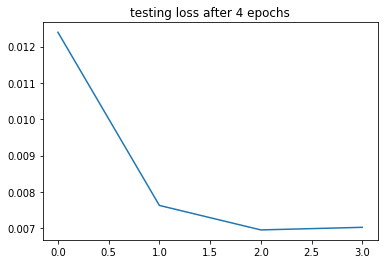







Training epoch 5

Train Epoch: 5 [0/10000 (0%)]	Loss: 0.005993
Train Epoch: 5 [640/10000 (6%)]	Loss: 0.008491
Train Epoch: 5 [1280/10000 (13%)]	Loss: 0.008394
Train Epoch: 5 [1920/10000 (19%)]	Loss: 0.008719
Train Epoch: 5 [2560/10000 (25%)]	Loss: 0.004722
Train Epoch: 5 [3200/10000 (32%)]	Loss: 0.006390
Train Epoch: 5 [3840/10000 (38%)]	Loss: 0.005112
Train Epoch: 5 [4480/10000 (45%)]	Loss: 0.005581
Train Epoch: 5 [5120/10000 (51%)]	Loss: 0.003996
Train Epoch: 5 [5760/10000 (57%)]	Loss: 0.005780
Train Epoch: 5 [6400/10000 (64%)]	Loss: 0.004788
Train Epoch: 5 [7040/10000 (70%)]	Loss: 0.005156
Train Epoch: 5 [7680/10000 (76%)]	Loss: 0.006435
Train Epoch: 5 [8320/10000 (83%)]	Loss: 0.002872
Train Epoch: 5 [8960/10000 (89%)]	Loss: 0.002070
Train Epoch: 5 [9600/10000 (96%)]	Loss: 0.003663


Details with sample from final batch:

Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.7120829224586487, dimming (predicted): 0.7179792523384094


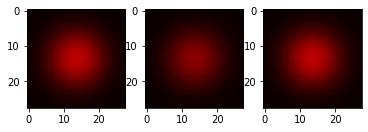


Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.6274987459182739, dimming (predicted): 0.6156102418899536


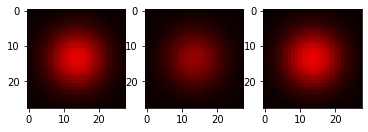


Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.3113909959793091, dimming (predicted): 0.2997364401817322


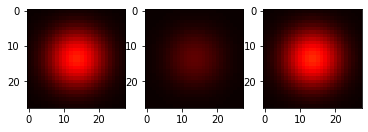


Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.8456661105155945, dimming (predicted): 0.8492832183837891


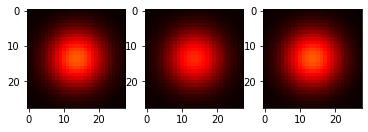


Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.250974178314209, dimming (predicted): 0.2306184023618698


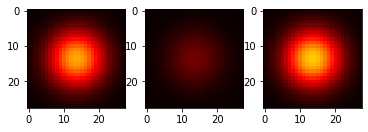


Channel: 5 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.4752774238586426, dimming (predicted): 0.4422568678855896


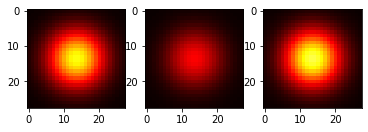


Channel: 6 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.7495823502540588, dimming (predicted): 0.7423353791236877


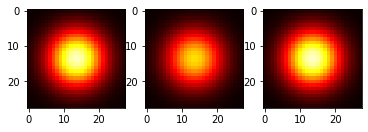

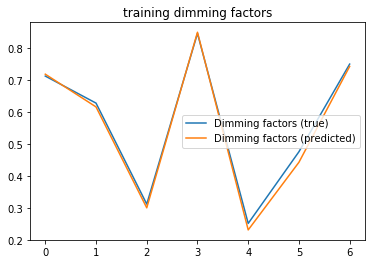

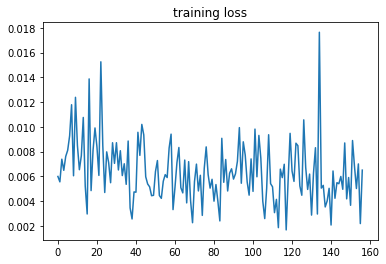


At end of train epoch 5, loss min: 0.0016740089049562812, max: 0.01764325425028801, mean: 0.006374556722510962


Testing epoch 5


Details with sample from final batch:

Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.05781584978103638, dimming (predicted): 0.09110920876264572


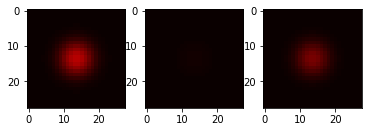


Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.021869301795959473, dimming (predicted): 0.06535191833972931


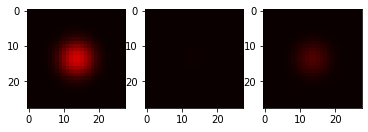


Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.868544340133667, dimming (predicted): 0.8689222931861877


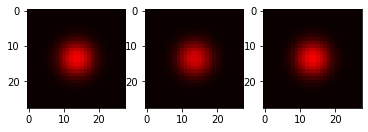


Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.3171219229698181, dimming (predicted): 0.2765113413333893


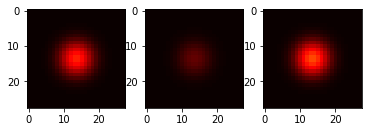


Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.6389278173446655, dimming (predicted): 0.7176729440689087


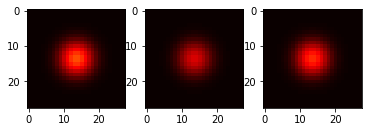


Channel: 5 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.5047062039375305, dimming (predicted): 0.5308855175971985


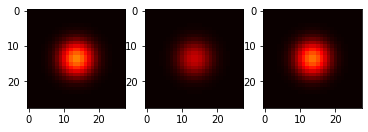


Channel: 6 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.6879337430000305, dimming (predicted): 0.7557291984558105


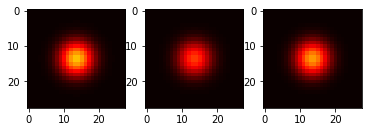

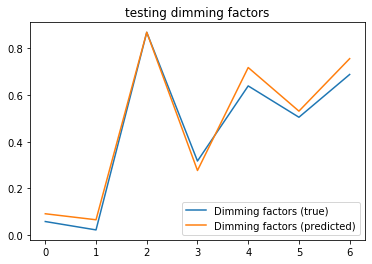



Random sample of mean predictions across channels for test set, where each row is a test sample in the training batch:

 Pred    GT  Delta  Pct Correct
 0.43  0.41   0.02         86.0
 0.32  0.29   0.03         71.0
 0.57  0.57   0.03         71.0


Epoch 5, test set: avg. loss: 0.00538859, Accuracy all channels correct: 290/1000 (29%)


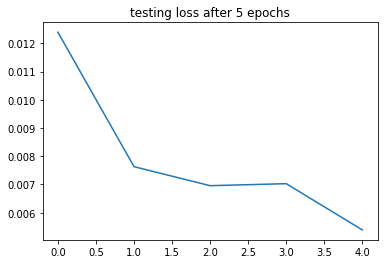



Final mean training loss after 5 epochs: 0.010552940419341208
Final mean testing loss after 5 epochs: 0.007878741901367902


In [10]:
train_losses = []
test_losses = []
for epoch in range(1, num_epochs + 1):
  train_losses.append(train(epoch))
  test_losses.append(test(epoch))
  
  plt.plot(test_losses, label='testing loss')
  plt.title('testing loss after {} epochs'.format(epoch))
  plt.show()
  
print('\n\nFinal mean training loss after {} epochs: {}'.format(
  num_epochs, np.mean(train_losses)))
print('Final mean testing loss after {} epochs: {}'.format(
  num_epochs, np.mean(test_losses)))